# Generator
Build generator architecture with:
* Attention blocks
* Spectral Convolutions
* Upsampling and Downsampling layers
* Resnet blocks

In [1]:
import tensorflow as tf

def attention_block(x, filters):
    """Self-attention mechanism to capture long-range dependencies"""
    batch_size = tf.shape(x)[0]
    height = tf.shape(x)[1]
    width = tf.shape(x)[2]
    
    # Change reshape operations to use tf.shape for dynamic batch size
    f = tf.keras.layers.Conv2D(filters // 8, 1)(x)
    g = tf.keras.layers.Conv2D(filters // 8, 1)(x)
    h = tf.keras.layers.Conv2D(filters, 1)(x)
    
    # Reshape using tf.reshape with properly specified dimensions
    f = tf.reshape(f, [batch_size, height * width, filters // 8])
    g = tf.reshape(g, [batch_size, height * width, filters // 8])
    h = tf.reshape(h, [batch_size, height * width, filters])
    
    # Compute attention map
    s = tf.matmul(f, g, transpose_b=True)
    beta = tf.nn.softmax(s)
    
    o = tf.matmul(beta, h)
    o = tf.reshape(o, [batch_size, height, width, filters])
    
    # Gamma as learnable parameter (can be initialized to 0)
    gamma = tf.Variable(0.0, trainable=True)
    return x + gamma * o

def spectral_conv2d(filters, kernel_size, strides=1):
    return tf.keras.layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        padding='same',
        kernel_initializer='orthogonal',
        use_bias=False
    )

def downsample(filters, size, apply_batchnorm=True):
    result = tf.keras.Sequential()
    result.add(spectral_conv2d(filters, size, strides=2))
    
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    
    result.add(tf.keras.layers.PReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(
            filters, size, strides=2,
            padding='same',
            kernel_initializer='orthogonal',
            use_bias=False
        )
    )
    
    result.add(tf.keras.layers.LayerNormalization())
    
    if apply_dropout:
        result.add(tf.keras.layers.SpatialDropout2D(0.5))
    
    result.add(tf.keras.layers.PReLU())
    return result

def resnet_block(input_tensor, filters, kernel_size=3):
    def squeeze_excite_block(input_tensor, ratio=16):
        channels = input_tensor.shape[-1]
        
        se = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
        se = tf.keras.layers.Reshape((1, 1, channels))(se)
        se = tf.keras.layers.Dense(channels // ratio, activation='relu')(se)
        se = tf.keras.layers.Dense(channels, activation='sigmoid')(se)
        
        return tf.keras.layers.Multiply()([input_tensor, se])
    
    x = spectral_conv2d(filters, kernel_size)(input_tensor)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    
    x = spectral_conv2d(filters, kernel_size)(x)
    x = tf.keras.layers.LayerNormalization()(x)
    
    x = squeeze_excite_block(x)
    x = tf.keras.layers.Add()([x, input_tensor])
    x = tf.keras.layers.PReLU()(x)
    
    return x

def build_generator(input_shape=(64, 64, 3)):
    # Input: 64x64
    tf.keras.backend.set_floatx('float32')
    inputs = tf.keras.layers.Input(shape=input_shape)

    
    # Initial convolution: 64x64 -> 64x64
    x = spectral_conv2d(32, 7)(inputs)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    
    # Downsampling path
    down_stack = [
        downsample(64, 3, apply_batchnorm=False),   # 64x64 -> 32x32
        downsample(128, 3),                         # 32x32 -> 16x16
        downsample(256, 3),                         # 16x16 -> 8x8
    ]
    
    # Using more ResNet blocks since we have a smaller architecture
    num_res_blocks = 9 # Increased from 6
    
    # Upsampling path
    up_stack = [
        upsample(128, 3, apply_dropout=True),       # 8x8 -> 16x16
        upsample(64, 3),                           # 16x16 -> 32x32
        upsample(32, 3),                           # 32x32 -> 64x64
    ]

    OUTPUT_CHANNELS = 3
    # Final output layer: 64x64 -> 128x128
    last = tf.keras.layers.Conv2DTranspose(
        OUTPUT_CHANNELS, 4,
        strides=2,
        padding='same',
        kernel_initializer='orthogonal',
        activation='tanh'
    )
    
    # Encoder
    x = inputs  # 64x64
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    # Print shapes for verification
    print(f"Bottleneck shape before ResNet blocks: {x.shape}")  # Should be (None, 8, 8, 256)
    
    # ResNet blocks at 8x8 resolution
    for _ in range(num_res_blocks):
        x = resnet_block(x, filters=256)  # Reduced from 512 due to smaller size
        if _ % 2 == 0:
            x = attention_block(x, filters=256)
    
    # Decoder
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = attention_block(x, x.shape[-1])
        x = tf.keras.layers.Concatenate()([x, skip])
    
    # Final output: 64x64 -> 128x128
    outputs = last(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

2024-11-18 12:21:51.883423: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 12:21:51.883485: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 12:21:51.883513: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 12:21:51.890199: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
generator = build_generator()
generator.summary()

2024-11-18 12:21:53.268770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-18 12:21:53.273879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-18 12:21:53.273926: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-18 12:21:53.278597: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-18 12:21:53.278674: I tensorflow/compile

Bottleneck shape before ResNet blocks: (None, 8, 8, 256)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32, 32, 64)           67264     ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 16, 16, 128)          107008    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 8, 8, 256)            312320    ['sequential_1[0][0]']        
                                     

# Discriminator
Build discriminator architecture:

In [3]:
# DISCRIMINATOR
import tensorflow as tf
import tensorflow_addons as tfa
    
from tensorflow.keras import layers
import numpy as np

def build_discriminator(input_shape=(64, 64, 3)):
    """
    Stabilized PatchGAN discriminator with spectral normalization and smooth activation
    """
    def conv_block(x, filters, kernel_size=4, strides=2):
        # Add spectral normalization
        x = tfa.layers.SpectralNormalization(
            layers.Conv2D(filters, kernel_size, strides, padding='same',
                         kernel_initializer='orthogonal', use_bias=False))(x)
        
        # Use GroupNormalization instead of BatchNorm/LayerNorm
        #x = tfa.layers.GroupNormalization(groups=8)(x) # Groupnorm as suggested
        x = layers.LayerNormalization()(x) # Layernorm could be more stable
        
        # Smoother activation function
        x = tf.nn.selu(x)  # Using SELU for self-normalizing properties
        return x

    inp = layers.Input(shape=input_shape, dtype=tf.float32, name='input_image')
    tar = layers.Input(shape=input_shape, dtype=tf.float32, name='target_image')
    
    # Add noise to inputs for smoothing
    noise_stddev = 0.01
    noised_inp = inp + tf.random.normal(tf.shape(inp), 0, noise_stddev)
    noised_tar = tar + tf.random.normal(tf.shape(tar), 0, noise_stddev)
    
    x = layers.Concatenate(axis=-1)([noised_inp, noised_tar])
    
    # Gradual filter increase
    x = conv_block(x, 32)          # (32x32x32)
    x = conv_block(x, 64)          # (16x16x64)
    x = conv_block(x, 128)         # (8x8x128)
    x = conv_block(x, 256)         # (4x4x256)
    
    # Final layer with smaller kernel and no activation
    output = layers.Conv2D(1, 1, 1, padding='same',
                          kernel_initializer='orthogonal',
                          activation='linear')(x)
    
    return tf.keras.Model(inputs=[inp, tar], outputs=output)

/home/megger/miniconda3/envs/pressure_predict/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
# DISCRIMINATOR
import tensorflow as tf
import tensorflow_addons as tfa
    
from tensorflow.keras import layers
import numpy as np

def build_discriminator(input_shape=(64, 64, 3)):
    """
    Stabilized PatchGAN discriminator with improved loss scaling
    """
    def conv_block(x, filters, kernel_size=4, strides=2, apply_norm=True):
        # Use smaller initialization for better stability
        x = tfa.layers.SpectralNormalization(
            layers.Conv2D(filters, kernel_size, strides, padding='same',
                         kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01),
                         use_bias=False))(x)
        
        if apply_norm:
            x = tfa.layers.InstanceNormalization()(x)
        
        x = layers.LeakyReLU(alpha=0.2)(x)
        return x

    inp = layers.Input(shape=input_shape, dtype=tf.float32, name='input_image')
    tar = layers.Input(shape=input_shape, dtype=tf.float32, name='target_image')
    
    # Reduced noise scale
    noise_scale = tf.Variable(0.001, trainable=True)
    noise = tf.random.normal(tf.shape(inp)) * noise_scale
    x = layers.Concatenate(axis=-1)([inp + noise, tar + noise])
    
    # More gradual filter progression
    x = conv_block(x, 32, strides=2)        # 32x32
    x = conv_block(x, 64, strides=2)        # 16x16
    x = conv_block(x, 128, strides=2)       # 8x8
    x = conv_block(x, 256, strides=1)       # 8x8
    
    # Final layer with smaller kernel
    x = layers.Conv2D(1, 3, strides=1, padding='same',
                     kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
    
    return tf.keras.Model(inputs=[inp, tar], outputs=x)

In [5]:
discriminator = build_discriminator()
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 tf.compat.v1.shape_21 (TFO  (4,)                         0         ['input_image[0][0]']         
 pLambda)                                                                                         
                                                                                                  
 tf.random.normal (TFOpLamb  (None, 64, 64, 3)            0         ['tf.compat.v1.shape_21[0][0]'
 da)                                                                ]                             
                                                                                            

# Loss function class
An object with physics-informed loss for the generator and discriminator

In [6]:
import tensorflow as tf

class FluidGANLoss:
    def __init__(self, discriminator, lambda_gp=10.0, lambda_physics=1.0):
        self.discriminator = discriminator
        self.lambda_gp = lambda_gp
        self.lambda_physics = lambda_physics
        # Add adaptive weights
        self.adversarial_weight = tf.Variable(1.0, trainable=False)
        self.running_gen_loss = tf.Variable(0.0, trainable=False)
        self.running_disc_loss = tf.Variable(0.0, trainable=False)
        self.beta = 0.99  # For running average
        
    def generator_loss(self, disc_generated_output, y_true, y_pred):
        # Use least squares GAN loss instead of relativistic
        # This tends to be more stable for fluid dynamics
        adversarial_loss = tf.reduce_mean(tf.square(disc_generated_output - 1.0))
        
        # Enhanced L1 loss with focus on high-gradient regions
        base_l1 = tf.abs(y_true - y_pred)
        grad_weights = tf.reduce_mean(tf.image.sobel_edges(y_true), axis=-1)
        grad_weights = tf.nn.softmax(grad_weights * 10.0)  # Temperature scaling
        weighted_l1 = base_l1 * (1.0 + grad_weights)
        l1_loss = tf.reduce_mean(weighted_l1)
        
        # Gradient matching with different scales
        grad_loss = 0.0
        scales = [1, 2]
        for scale in scales:
            if scale > 1:
                y_true_scaled = tf.nn.avg_pool2d(y_true, scale, scale, 'VALID')
                y_pred_scaled = tf.nn.avg_pool2d(y_pred, scale, scale, 'VALID')
            else:
                y_true_scaled = y_true
                y_pred_scaled = y_pred
                
            true_grads = tf.image.sobel_edges(y_true_scaled)
            pred_grads = tf.image.sobel_edges(y_pred_scaled)
            grad_loss += tf.reduce_mean(tf.abs(true_grads - pred_grads))
        
        # Physics loss with adaptive weight
        physics_loss = self.physics_consistency_loss(y_pred)
        physics_weight = tf.minimum(1.0, tf.cast(self.running_gen_loss, tf.float32) / 2.0)
        
        # Dynamically adjust weights based on running losses
        l1_weight = 50.0  # Reduced from 100.0
        grad_weight = 10.0  # Reduced from 25.0
        
        total_loss = (
            self.adversarial_weight * adversarial_loss + 
            l1_weight * l1_loss +
            grad_weight * grad_loss + 
            physics_weight * self.lambda_physics * physics_loss
        )
        
        # Update running average of generator loss
        self.running_gen_loss.assign(
            self.beta * self.running_gen_loss + (1 - self.beta) * total_loss
        )
        
        return {
            'total_loss': total_loss,
            'adversarial_loss': adversarial_loss,
            'l1_loss': l1_loss,
            'grad_loss': grad_loss,
            'physics_loss': physics_loss,
            'physics_weight': physics_weight
        }
    
    def discriminator_loss(self, disc_real_output, disc_generated_output, 
                          real_images, generated_images, batch_size):
        # Use least squares GAN loss for discriminator
        real_loss = tf.reduce_mean(tf.square(disc_real_output - 1.0))
        fake_loss = tf.reduce_mean(tf.square(disc_generated_output))
        
        # Calculate gradient penalty with adaptive weight
        gp = self.gradient_penalty(real_images, generated_images, batch_size)
        gp_weight = tf.minimum(10.0, 2.0 * tf.cast(self.running_disc_loss, tf.float32))
        
        total_loss = real_loss + fake_loss + gp_weight * gp
        
        # Update running average of discriminator loss
        self.running_disc_loss.assign(
            self.beta * self.running_disc_loss + (1 - self.beta) * total_loss
        )
        
        # Adjust adversarial weight for generator based on discriminator performance
        disc_ratio = real_loss / (fake_loss + 1e-6)
        self.adversarial_weight.assign(
            tf.clip_by_value(self.adversarial_weight * tf.sqrt(disc_ratio), 0.5, 2.0)
        )
        
        return {
            'total_loss': total_loss,
            'real_loss': real_loss,
            'fake_loss': fake_loss,
            'gradient_penalty': gp,
            'gp_weight': gp_weight
        }
    
    def physics_consistency_loss(self, y_pred):
        """Physics-based loss focusing on fluid dynamics constraints"""
        # Calculate velocity gradients using central differences
        dx = (y_pred[:, 2:, 1:-1, :] - y_pred[:, :-2, 1:-1, :]) / 2.0
        dy = (y_pred[:, 1:-1, 2:, :] - y_pred[:, 1:-1, :-2, :]) / 2.0
        
        # Divergence-free constraint
        divergence = dx + dy
        divergence_loss = tf.reduce_mean(tf.square(divergence))
        
        # Add smoothness constraint for better stability
        smoothness_loss = tf.reduce_mean(tf.square(dx)) + tf.reduce_mean(tf.square(dy))
        
        # Boundary conditions
        boundary_loss = tf.reduce_mean(tf.square(y_pred[:, 0, :, :]) + 
                                     tf.square(y_pred[:, -1, :, :]) +
                                     tf.square(y_pred[:, :, 0, :]) + 
                                     tf.square(y_pred[:, :, -1, :]))
        
        return divergence_loss + 0.1 * smoothness_loss + 0.05 * boundary_loss
    
    def gradient_penalty(self, real_images, fake_images, batch_size):
        """Calculate gradient penalty with improved interpolation"""
        # Use random interpolation points
        alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff
        
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            disc_interpolated = self.discriminator([interpolated, real_images], 
                                                 training=True)
        
        gradients = tape.gradient(disc_interpolated, interpolated)
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]) + 1e-8)
        return tf.reduce_mean(tf.square(slopes - 1.0))

# Training setup
An object containing all the necessary capabilities to train the model and preview progress

In [7]:
import matplotlib.pyplot as plt

def generate_images(model, test_input, tar):
    """ Generates and displays a comparison between input image, 
    ground truth and predicted image from a model.
    """
    prediction = model(test_input, training=True)
    plt.figure(figsize=(10, 10))
    value_range = .05

    display_list = [
        test_input[0][:,:,0], tar[0][:,:,0], prediction[0][:,:,0],
        test_input[0][:,:,1], tar[0][:,:,1], prediction[0][:,:,1],
        test_input[0][:,:,2], tar[0][:,:,2], prediction[0][:,:,2] 
    ]
    maintitle = ['Input Image', 'Ground Truth', 'Predicted Image']
    title = ['vel.x', 'vel.y', 'pressure']

    for i in range(9):
        plt_idx = i
        plt.subplot(3, 3, i+1)
        
        try: header = f"----- {maintitle[i]} -----"
        except: header = ""
        plt.title(f"{header}\n\n{title[i//3]}", fontsize=11)
        
        # Getting the pixel values in the [0, 1] range to plot.
        a, b = 0.5, 0.1
        tile = display_list[i]
        # if (i-2)%3 == 0:
        #     # Blur prediction with gaussian sigma
        #     BLUR_SIGMA = 0.35
        #     tile = scipy.ndimage.gaussian_filter(tile, BLUR_SIGMA)
        plt.imshow(tile, vmin=-value_range, vmax=value_range)
        plt.axis('off')
    plt.show()

In [8]:
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import datetime
import numpy as np

class FluidGANTrainer:
    def __init__(
        self,
        generator,
        discriminator,
        train_dataset,
        test_dataset,
        checkpoint_dir='./training_checkpoints',
        preview_interval=10,
        checkpoint_interval=50,
        validation_interval=5,
        samples_per_epoch=2000,  # New parameter for controlling epoch size
        log_rate=100
    ):
        self.generator = generator
        self.discriminator = discriminator
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.checkpoint_dir = checkpoint_dir
        self.preview_interval = preview_interval
        self.checkpoint_interval = checkpoint_interval
        self.validation_interval = validation_interval
        self.samples_per_epoch = samples_per_epoch
        self.log_rate = log_rate
                
        # Add learning rate scheduling
        initial_lr_gen = 2e-4
        initial_lr_disc = 5e-5
        self.generator_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_lr_gen, decay_steps=2000, decay_rate=0.98, staircase=True)
        self.discriminator_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_lr_disc, decay_steps=2000, decay_rate=0.98, staircase=True)
        
        # Initialize optimizers
        self.generator_optimizer = tf.keras.optimizers.Adam(
            self.generator_scheduler, beta_1=0.5, beta_2=0.9)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(
            self.discriminator_scheduler, beta_1=0.0, beta_2=0.9, epsilon=1e-8)
        
        # Initialize loss function
        self.loss_fn = FluidGANLoss(discriminator=self.discriminator, lambda_gp=10.0, lambda_physics=0.0)
        
        # Setup checkpointing
        self.checkpoint = tf.train.Checkpoint(
            generator_optimizer=self.generator_optimizer,
            discriminator_optimizer=self.discriminator_optimizer,
            generator=self.generator,
            discriminator=self.discriminator
        )
        self.checkpoint_manager = tf.train.CheckpointManager(
            self.checkpoint, self.checkpoint_dir, max_to_keep=10
        )
        
        # Setup logging
        current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        self.log_dir = f'logs/{current_time}'
        self.summary_writer = tf.summary.create_file_writer(self.log_dir)

    def create_epoch_dataset(self, full_dataset, num_samples, batch_size=1):
        """Create a smaller dataset for one epoch by sampling randomly"""
        # Convert dataset to numpy for easier sampling
        
        inputs, targets = [], []
        for x, y in full_dataset:
            inputs.append(x)
            targets.append(y)
        inputs = np.concatenate(inputs, axis=0)
        targets = np.concatenate(targets, axis=0)
        
        # Randomly sample indices
        total_samples = inputs.shape[0]
        indices = np.random.choice(total_samples, num_samples, replace=False)
        
        # Create new dataset from sampled data
        sampled_inputs = inputs[indices]
        sampled_targets = targets[indices]
        
        # Create TF dataset
        dataset = tf.data.Dataset.from_tensor_slices((sampled_inputs, sampled_targets))
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        
        return dataset

    @tf.function
    def train_step(self, input_image, target_image):
        """Single training step"""
        batch_size = tf.shape(input_image)[0]
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Generator forward pass
            gen_output = self.generator(input_image, training=True)
            
            # Discriminator forward passes
            disc_real_output = self.discriminator([input_image, target_image], training=True)
            disc_generated_output = self.discriminator([input_image, gen_output], training=True)
            
            # Calculate losses
            gen_losses = self.loss_fn.generator_loss(
                disc_generated_output, target_image, gen_output
            )
            disc_losses = self.loss_fn.discriminator_loss(
                disc_real_output, disc_generated_output,
                target_image, gen_output, batch_size
            )
        
        # Calculate gradients
        generator_gradients = gen_tape.gradient(
            gen_losses['total_loss'],
            self.generator.trainable_variables
        )
        discriminator_gradients = disc_tape.gradient(
            disc_losses['total_loss'],
            self.discriminator.trainable_variables
        )
        
        # Apply gradient clipping
        generator_gradients = [tf.clip_by_norm(g, 1.0) for g in generator_gradients]
        discriminator_gradients = [tf.clip_by_norm(g, 1.0) for g in discriminator_gradients]
        
        # Apply gradients
        self.generator_optimizer.apply_gradients(
            zip(generator_gradients, self.generator.trainable_variables)
        )
        self.discriminator_optimizer.apply_gradients(
            zip(discriminator_gradients, self.discriminator.trainable_variables)
        )
        
        return gen_losses, disc_losses

    
    @tf.function
    def validation_step(self, input_image, target_image):
        """Single validation step without gradient updates"""
        batch_size = tf.shape(input_image)[0]
        
        # Generator forward pass
        gen_output = self.generator(input_image, training=False)
        
        # Discriminator forward passes
        disc_real_output = self.discriminator([input_image, target_image], training=False)
        disc_generated_output = self.discriminator([input_image, gen_output], training=False)
        
        # Calculate losses
        gen_losses = self.loss_fn.generator_loss(
            disc_generated_output, target_image, gen_output
        )
        disc_losses = self.loss_fn.discriminator_loss(
            disc_real_output, disc_generated_output,
            target_image, gen_output, batch_size
        )
        
        return gen_losses, disc_losses

    def validate_model(self):
        """Run validation on the test dataset"""
        total_gen_loss = 0
        total_disc_loss = 0
        num_batches = 0
        
        for input_image, target_image in self.test_dataset:
            gen_losses, disc_losses = self.validation_step(input_image, target_image)
            total_gen_loss += gen_losses['total_loss']
            total_disc_loss += disc_losses['total_loss']
            num_batches += 1
        
        avg_gen_loss = total_gen_loss / num_batches
        avg_disc_loss = total_disc_loss / num_batches
        
        return {
            'generator_loss': avg_gen_loss,
            'discriminator_loss': avg_disc_loss
        }

    def train(self, epochs, batch_size=1):
        """Main training loop with epoch sampling"""
        start = time.time()
        
        # Try to restore latest checkpoint
        if self.checkpoint_manager.latest_checkpoint:
            self.checkpoint.restore(self.checkpoint_manager.latest_checkpoint)
            print(f'Latest checkpoint restored from {self.checkpoint_manager.latest_checkpoint}')
        
        # Get a test batch for previewing results
        test_input, test_target = next(iter(self.test_dataset))
        
        for epoch in range(epochs):
            start_time = time.time()
            
            # Create a new sampled dataset for this epoch
            epoch_dataset = self.create_epoch_dataset(
                self.train_dataset, 
                self.samples_per_epoch, 
                batch_size
            )
            
            # Train on batches
            for batch_idx, (input_image, target_image) in enumerate(epoch_dataset):
                gen_losses, disc_losses = self.train_step(input_image, target_image)
                
                # Log every @log_rate batches
                if batch_idx % self.log_rate == 0:
                    print(f'Epoch {epoch+1}, Batch {batch_idx}:')
                    gen_lr = self.generator_scheduler(self.generator_optimizer.iterations)
                    disc_lr = self.discriminator_scheduler(self.discriminator_optimizer.iterations)
                    print(f'Generator Loss: {gen_losses["total_loss"]:.4f},  LR: {gen_lr:.2e}')
                    print(f'Discriminator Loss: {disc_losses["total_loss"]:.4f},  LR: {disc_lr:.2e}')
                    
                    # Log to TensorBoard
                    with self.summary_writer.as_default():
                        step = epoch * (self.samples_per_epoch // batch_size) + batch_idx
                        tf.summary.scalar('train/gen_total_loss', gen_losses['total_loss'], step=step)
                        tf.summary.scalar('train/gen_adversarial_loss', gen_losses['adversarial_loss'], step=step)
                        tf.summary.scalar('train/l1_loss', gen_losses['l1_loss'], step=step)
                        tf.summary.scalar('train/gen_physics_loss', gen_losses['physics_loss'], step=step)
                        tf.summary.scalar('train/disc_total_loss', disc_losses['total_loss'], step=step)

                        
            # Run validation
            if (epoch + 1) % self.validation_interval == 0:
                val_losses = self.validate_model()
                print(f'Validation Losses:')
                print(f'Generator Loss: {val_losses["generator_loss"]:.4f}')
                print(f'Discriminator Loss: {val_losses["discriminator_loss"]:.4f}')
                
                # Log validation metrics
                with self.summary_writer.as_default():
                    tf.summary.scalar('validation/gen_loss', val_losses['generator_loss'], step=(epoch + 1))
                    tf.summary.scalar('validation/disc_loss', val_losses['discriminator_loss'], step=(epoch + 1))
            
            # Preview images
            if (epoch + 1) % self.preview_interval == 0:
                generate_images(self.generator, test_input, test_target)
            
            # Save checkpoint
            if (epoch + 1) % self.checkpoint_interval == 0:
                self.checkpoint_manager.save()
                print(f'Checkpoint saved for epoch {epoch+1}')
            
            print(f'Epoch {epoch+1} took {time.time()-start_time:.2f} seconds')
        
        print(f'Training took {time.time()-start} seconds')

# Ingest Data, build datasets, run training
Load concatenated data output by "pressure_predict_1_data_prep"

In [9]:
import numpy as np
import time

start_time = time.perf_counter()
combined_data_path = "./data2D/loaded_data_v2_rand.npz"
with np.load(combined_data_path) as data:
    X_train = data["X_train"]
    Y_train = data["Y_train"]
    X_test  = data["X_test"]
    Y_test  = data["Y_test"]

end_time = time.perf_counter()
print(f"Loaded combined array in {end_time - start_time:.2f} seconds.")
print("Loaded X shape: ", np.array(X_train).shape, np.array(X_test).shape)
print("Loaded Y shape: ", np.array(Y_train).shape, np.array(Y_test).shape)

# Normally returns:
# Loaded X shape:  (5000, 64, 64, 3) (1000, 64, 64, 3)
# Loaded Y shape:  (5000, 64, 64, 3) (1000, 64, 64, 3)

Loaded combined array in 8.38 seconds.
Loaded X shape:  (5000, 64, 64, 3) (1000, 64, 64, 3)
Loaded Y shape:  (5000, 64, 64, 3) (1000, 64, 64, 3)


2024-11-18 12:22:10.257279: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-11-18 12:22:10.429948: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


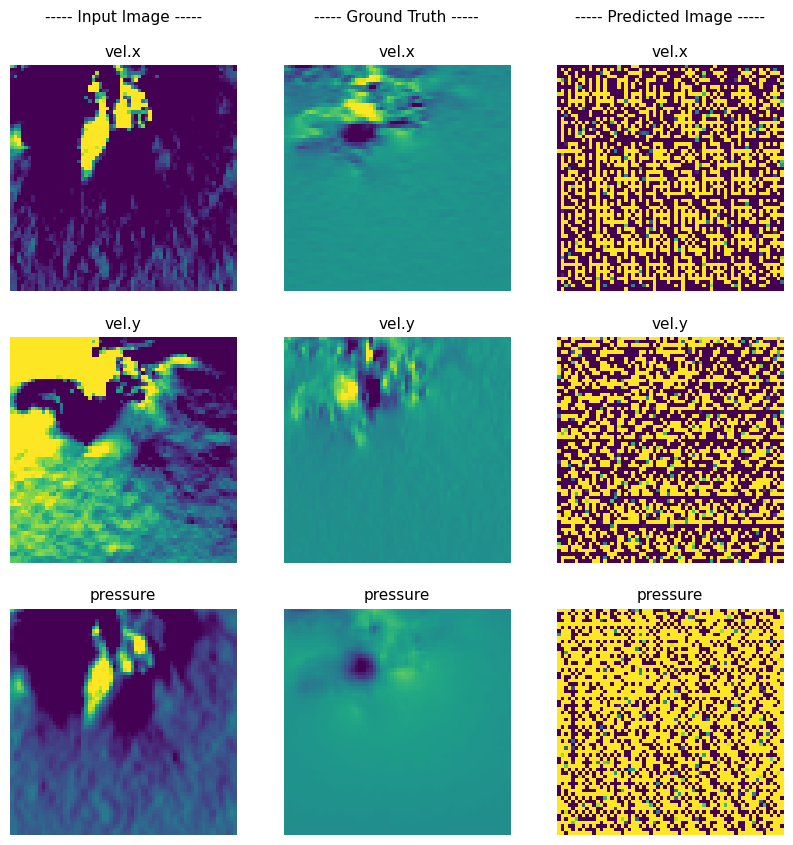

In [10]:
# Test untrained generator and preview.
prev_idx = 10
generate_images(generator, X_train[prev_idx][tf.newaxis, ...], Y_train[prev_idx][tf.newaxis, ...])

In [11]:
# APPLY BATCHING (with 1)
# ... and achieve output dimensionality of:     [2,     n, 64, 64, 3] 
# ... with desired iteration dimensionality of:     [None, 64, 64, 3]
import tensorflow as tf

X_train = tf.cast(X_train, tf.float32)
Y_train = tf.cast(Y_train, tf.float32)
X_test = tf.cast(X_test, tf.float32)
Y_test = tf.cast(Y_test, tf.float32)

# Normalize data to [-1, 1] range if not already done
# def normalize(x):
#     return tf.clip_by_value(x, -1, 1)

# X_train, Y_train = normalize(X_train), normalize(Y_train)
# X_test, Y_test = normalize(X_test), normalize(Y_test)

# Create datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_ds = train_ds.shuffle(5000).batch(5)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_ds = test_ds.shuffle(1000).batch(5)


In [12]:
import random
log_dir = "./logs"

%load_ext tensorboard
%reload_ext tensorboard
random_port = random.randrange(1001,9900)
print(f"Loading tensorboard on port: {random_port}")
%tensorboard --logdir={log_dir} --reload_multifile=true --port={random_port} --host localhost

Loading tensorboard on port: 1308


In [ ]:
# Initialize models
generator = build_generator()
discriminator = build_discriminator()

# Initialize trainer
trainer = FluidGANTrainer(
    generator=generator,
    discriminator=discriminator,
    train_dataset=train_ds,
    test_dataset=test_ds,
    checkpoint_dir='./training_checkpointsF',
    preview_interval=5,
    checkpoint_interval=20,
    validation_interval=10,
    samples_per_epoch=4000,
    log_rate=200
)

# Start training
trainer.train(epochs=800, batch_size=5)

In [ ]:
import netron
model = "./models/pressure_predict_D_v0.h5"
netron.start(model)